In [2]:
# Step 1: Libraries import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
# Step 2: Load dataset
# Replace 'uidai_data.csv' with your actual file
df = pd.read_csv("api_data_aadhar_enrolment_500000_1000000.csv")


In [26]:
print(df.head())
print(df.info())
print(df.describe())


         date           state  district  pincode  age_0_5  age_5_17  \
0  26-10-2025  Andhra Pradesh  Nalgonda   508004        0         1   
1  26-10-2025  Andhra Pradesh  Nalgonda   508238        1         0   
2  26-10-2025  Andhra Pradesh  Nalgonda   508278        1         0   
3  26-10-2025  Andhra Pradesh   Nandyal   518432        0         1   
4  26-10-2025  Andhra Pradesh   Nandyal   518543        1         0   

   age_18_greater  
0               0  
1               0  
2               0  
3               0  
4               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date            500000 non-null  object
 1   state           500000 non-null  object
 2   district        500000 non-null  object
 3   pincode         500000 non-null  int64 
 4   age_0_5         500000 non-null  int64 
 5   age_5_17        500000 

In [46]:
# Step 4: Total population per row
df["total_population"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]


In [47]:
# Step 5: Calculate PPI (Population Planning Index)
# Weights: 0-5 -> 1.5, 5-17 -> 1.2, 18+ -> 1.0
df["PPI"] = (df["age_0_5"] * 1.5) + (df["age_5_17"] * 1.2) + (df["age_18_greater"] * 1.0)


In [48]:
# Step 6: Aggregate at district level
district_df = df.groupby(["state","district"], as_index=False).agg({
    "age_0_5":"sum",
    "age_5_17":"sum",
    "age_18_greater":"sum",
    "total_population":"sum",
    "PPI":"sum"
})

In [49]:
# Step 7: Categorize PPI Priority Levels
def ppi_label(x):
    if x > 50000:
        return "High Priority"
    elif x > 30000:
        return "Medium Priority"
    else:
        return "Low Priority"

district_df["priority_category"] = district_df["PPI"].apply(ppi_label)

In [50]:
# Step 8: Additional Metrics
district_df["adult_percentage"] = (district_df["age_18_greater"] / district_df["total_population"]) * 100
district_df["youth_pressure_index"] = (district_df["age_5_17"] / district_df["age_18_greater"])


In [51]:
# Step 9: Top 10 High Priority Districts
top10 = district_df.sort_values("PPI", ascending=False).head(10)
print(top10[["state","district","PPI","priority_category","adult_percentage","youth_pressure_index"]])

           state           district      PPI priority_category  \
996  West Bengal  South 24 Parganas  24215.1      Low Priority   
984  West Bengal        Murshidabad  21936.2      Low Priority   
539  Maharashtra               Pune  19938.1      Low Priority   
548  Maharashtra              Thane  19605.6      Low Priority   
986  West Bengal  North 24 Parganas  17941.3      Low Priority   
736    Rajasthan             Jaipur  16501.6      Low Priority   
380    Karnataka          Bengaluru  13920.5      Low Priority   
124        Bihar     East Champaran  12868.3      Low Priority   
150        Bihar              Saran  12354.7      Low Priority   
999  West Bengal     Uttar Dinajpur  12351.6      Low Priority   

     adult_percentage  youth_pressure_index  
996          1.391580             17.059072  
984          0.452459             28.102941  
539          4.293201              3.658863  
548          1.743552             12.804167  
986          7.897621              2.372646

In [52]:
# Step 10: State-level Aggregation (Extra Insight)
state_df = district_df.groupby("state").agg({
    "PPI":"sum",
    "total_population":"sum"
}).reset_index()
state_df["avg_PPI_per_capita"] = state_df["PPI"] / state_df["total_population"]


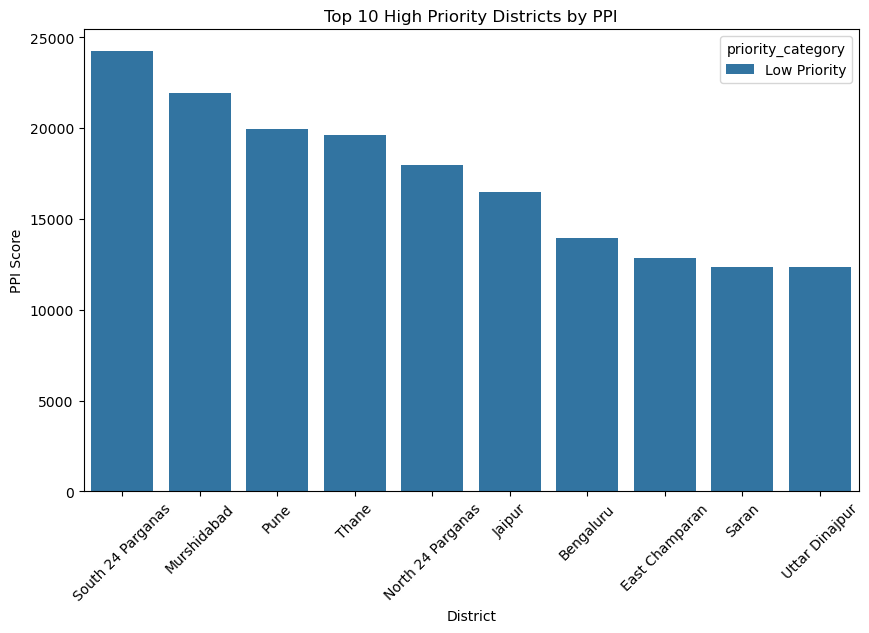

In [54]:
# Step 11: Visualizations

# 1. Bar chart: Top 10 High Priority Districts
plt.figure(figsize=(10,6))
sns.barplot(x="district", y="PPI", data=top10, hue="priority_category", dodge=False)
plt.title("Top 10 High Priority Districts by PPI")
plt.xticks(rotation=45)
plt.ylabel("PPI Score")
plt.xlabel("District")
plt.show()


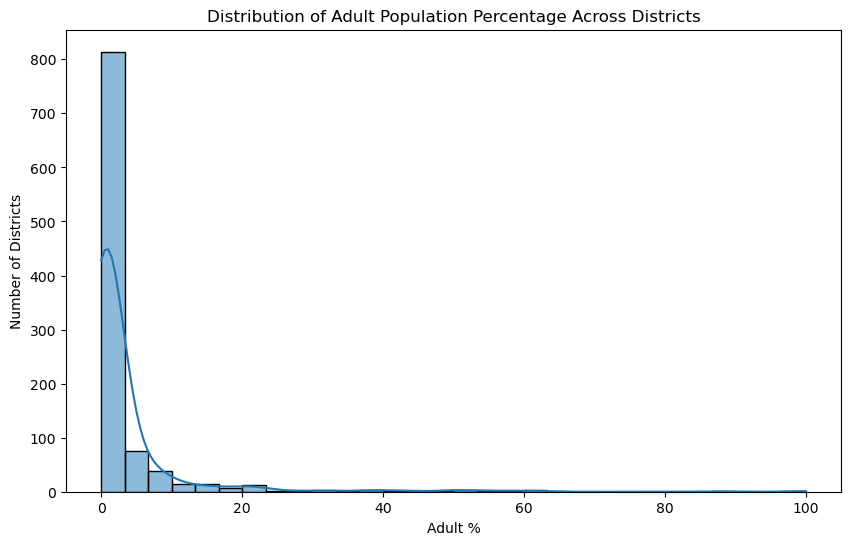

In [57]:

# 3. Histogram: Adult percentage distribution
plt.figure(figsize=(10,6))
sns.histplot(district_df["adult_percentage"], bins=30, kde=True)
plt.title("Distribution of Adult Population Percentage Across Districts")
plt.xlabel("Adult %")
plt.ylabel("Number of Districts")
plt.show()


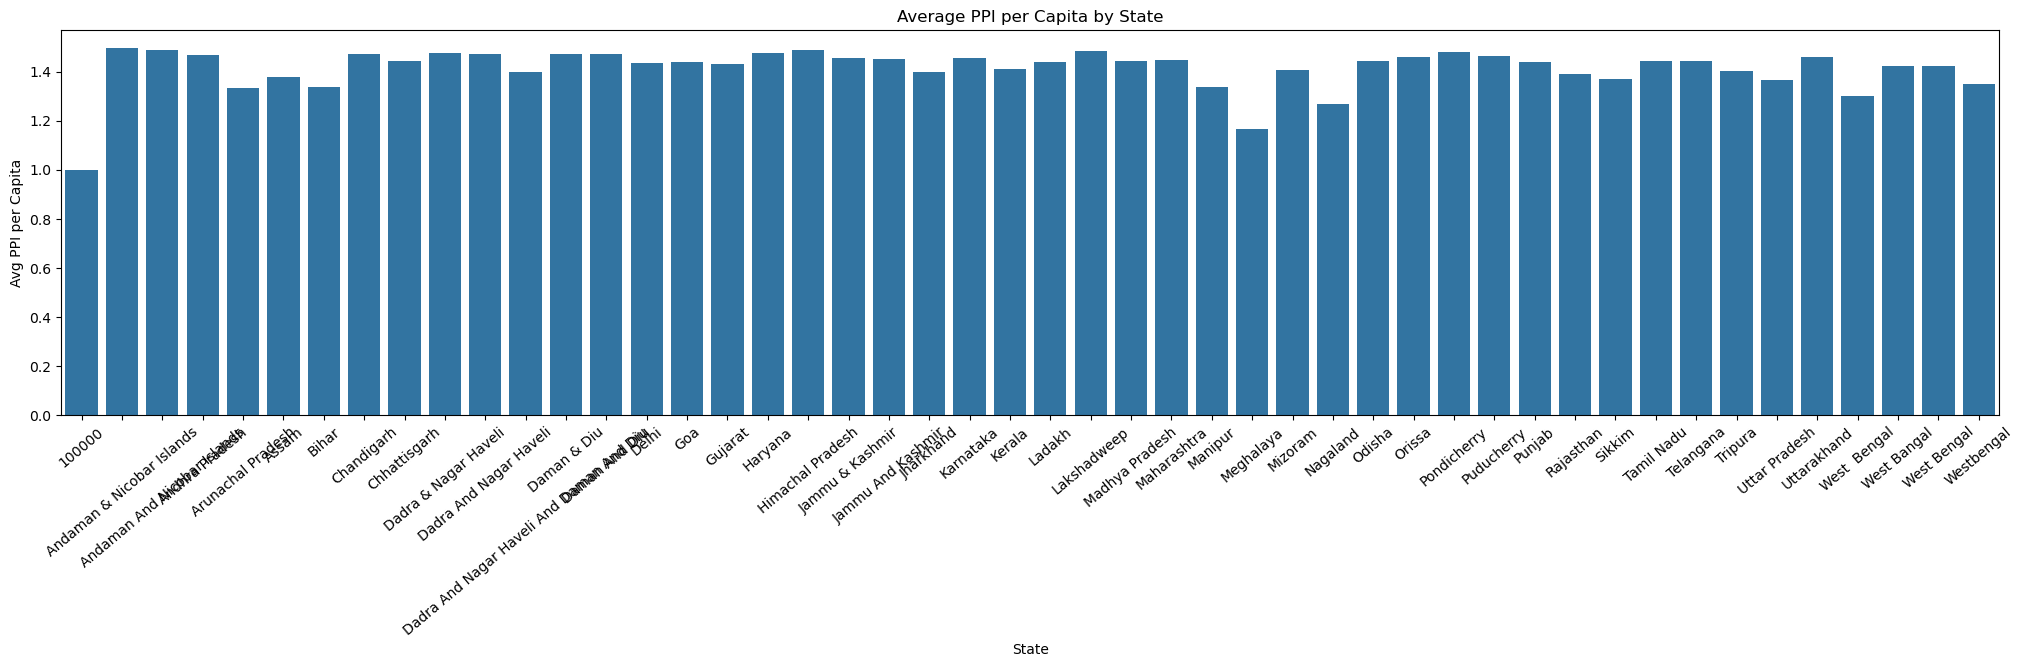

In [72]:
# 5. State-level PPI comparison
plt.figure(figsize=(25,5))
sns.barplot(x="state", y="avg_PPI_per_capita", data=state_df)
plt.title("Average PPI per Capita by State")
plt.xticks(rotation=40)
plt.ylabel("Avg PPI per Capita")
plt.xlabel("State")
plt.show()


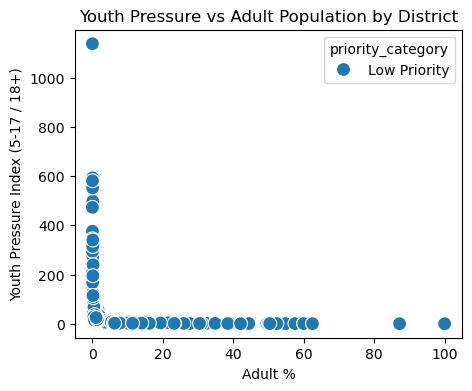

In [64]:
# 6. Scatter: Youth vs Adult ratio
plt.figure(figsize=(5,4))
sns.scatterplot(data=district_df, x="adult_percentage", y="youth_pressure_index", hue="priority_category", s=100)
plt.title("Youth Pressure vs Adult Population by District")
plt.xlabel("Adult %")
plt.ylabel("Youth Pressure Index (5-17 / 18+)")
plt.show()

In [63]:
# Step 12: Export tables for PPT
top10.to_csv("top10_high_priority_districts.csv", index=False)
district_df.to_csv("district_PPI_summary.csv", index=False)
state_df.to_csv("state_PPI_summary.csv", index=False)